## Ensemble Models
Here we will learn Ensemble Models which have become the models which are most widely used in every type of real world problem as it trains more that one models on the training dataset and hence learns on them and averages the accuracy of the all the learned models and hence performs well on the provided dataset.Due to the presence of many models we would be able to increase the generalization accuracy and hence decrease the variance.

### Ensemble Vs Base
Here we just show that how for different values of error we get different errors in Base and Ensemble model respectively and how it would be useful to implement ensemble models for lower level of errors as they tend to decrease the generalization error of base models.

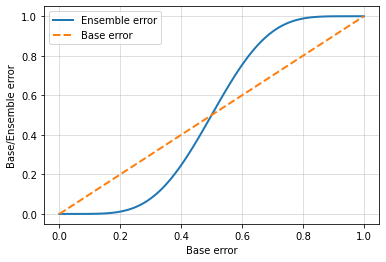

In [3]:
from scipy.special import comb
import math
import numpy as np
import matplotlib.pyplot as plt
def ensemble_error(n_classifier,error):
    k_start = int(math.ceil(n_classifier/2.))
    probs = [comb(n_classifier,k)*error**k*(1-error)**(n_classifier -  k) for k in range(k_start,n_classifier+1)]
    return sum(probs)

error_range = np.arange(0.0,1.01,0.01)
ens_errors = [ensemble_error(n_classifier=11,error=error) for error in error_range]
plt.plot(error_range,ens_errors,label = 'Ensemble error',linewidth= 2)
plt.plot(error_range,error_range,linestyle = '--',label = 'Base error',linewidth=2)
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc = 'upper left')
plt.grid(alpha = 0.5)
plt.show()
## Here  we can see that when we take only 11 classifiers together and when we evaluate their errors in ensemble cases we can easily see that the model's errors decrease drastically

### Preprocessing the Dataset
Here we just preprocess the dataset into a form so that it would be in a form so that we could use it for training our model.

In [5]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
iris = datasets.load_iris()
X,y = iris.data[50:,[1,2]],iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)
X_train , X_test , y_train, y_test = train_test_split(X,y,test_size = 0.5,stratify = y,random_state = 1)

In [6]:
## Here we evaluate three different classifiers on the selected dataset and check their ROC AUC values
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np

clf1 = LogisticRegression(penalty = 'l2',C = 0.001,random_state = 1)
clf2 = DecisionTreeClassifier(max_depth = 1,criterion = 'entropy',random_state = 0)
clf3 = KNeighborsClassifier(n_neighbors = 1,p = 2,metric = 'minkowski')
pipe1 = Pipeline([['sc',StandardScaler()],
                  ['clf',clf1]])
pipe3 = Pipeline([[ 'sc',StandardScaler()],
                  ['clf',clf3]])
clf_labels = ['Logistic regression','Decision Tree','KNN']
print('10-fold cross validation:\n')
for clf, label in zip([pipe1,clf2,pipe3],clf_labels):
    scores = cross_val_score(estimator = clf,
                             X = X_train,
                             y = y_train,
                             cv = 10,
                             scoring = 'roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(),scores.std(),label))

10-fold cross validation:

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision Tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]


In [7]:
## Here we just use the MajorityVoteClassifier to select the final label of the datapoint
## by using all the three classifiers and we can see that the model already performs really well on the dataset
from Ensembler import MajorityVoteClassifier
mv_clf = MajorityVoteClassifier(classifiers= [pipe1,clf2,pipe3])
clf_labels += ['Majority voting']
all_clf = [pipe1,clf2,pipe3,mv_clf]
for clf,label in zip(all_clf,clf_labels):
    scores = cross_val_score(estimator = clf,X=X_train,y=y_train,cv = 10,scoring = 'roc_auc')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" %(scores.mean(),scores.std(),label))

Accuracy: 0.92 (+/- 0.15) [Logistic regression]
Accuracy: 0.87 (+/- 0.18) [Decision Tree]
Accuracy: 0.85 (+/- 0.13) [KNN]
Accuracy: 0.98 (+/- 0.05) [Majority voting]


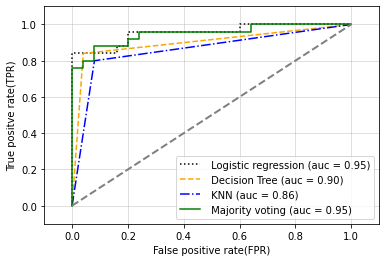

In [8]:
## Here we plot the ROC AUC curve for all the types of models trained and 
## we can easily see that the MVC performs the best which is equivalent to the Logistic Regression Model
## Hence Ensemble Models really work well the dataset when the individual models performs well enough
from sklearn.metrics import roc_curve,auc
colors = ['black','orange','blue','green']
linestyles = [':','--','-.','-']
for clf,label,clr,ls in zip(all_clf,clf_labels,colors,linestyles):
    y_pred = clf.fit(X_train,y_train).predict_proba(X_test)[:,1]
    fpr , tpr, thresholds = roc_curve(y_true = y_test,y_score = y_pred)
    roc_auc = auc(x=fpr,y=tpr)
    plt.plot(fpr,tpr,color = clr,linestyle = ls,label =' %s (auc = %0.2f)' % (label,roc_auc))
plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1],linestyle = '--',color = 'gray',linewidth = 2)
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.grid(alpha = 0.5)
plt.xlabel('False positive rate(FPR)')
plt.ylabel('True positve rate(TPR)')
plt.show()

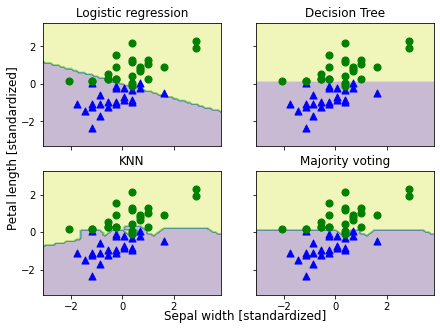

In [9]:
## Here we just plot the decision boundaries of the classifiers and visualize
## how well they differentiate the given datapoints on the basis of different classes
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
from itertools import product
x_min = X_train_std[:,0].min() - 1
x_max = X_train_std[:,0].max() + 1
y_min = X_train_std[:,1].min() - 1
y_max = X_train_std[:,1].max() + 1
xx , yy =np.meshgrid(np.arange(x_min,x_max,0.1),
                     np.arange(y_min,y_max,0.1))
f, axarr = plt.subplots(nrows = 2,ncols = 2,sharex = 'col',sharey = 'row',figsize = (7,5))
for idx, clf , tt in zip(product([0,1],[0,1]),
                         all_clf,clf_labels):
    clf.fit(X_train_std,y_train)
    Z = clf.predict(np.c_[xx.ravel(),yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0],idx[1]].contourf(xx,yy,Z,alpha = 0.3)
    axarr[idx[0],idx[1]].scatter(X_train_std[y_train==0,0],
                                 X_train_std[y_train==0,1],
                                 c = 'blue',marker = '^',s = 50)
    axarr[idx[0],idx[1]].scatter(X_train_std[y_train==1,0],
                                 X_train_std[y_train==1,1],
                                 c = 'green',marker = 'o',s = 50)
    axarr[idx[0],idx[1]].set_title(tt)
    
plt.text(-3.5,-4.5,s = 'Sepal width [standardized]',ha = 'center',va = 'center',fontsize = 12)
plt.text(-12.5,4.5,s = 'Petal length [standardized]',ha = 'center',va = 'center',fontsize = 12,rotation = 90)
plt.show()

## Bagging
Bagging is another important method when we talk about Ensemble Methods as they also largely help in decreasing the generalization error and it is very similar to the previous Ensemble Method that we have implemented.The Ensemble Method largely use the idea that we train different classifier on the whole training set and hence take their accuracy average but in case of bagging we say that we take bootstrap samples(random samples) from the dataset for training each different classifier and then take the average accuracy of the classifiers trained and this thus helps in decreasing the generalization error as due to this we tend to decrease the factor of bias that could come into effect by training all the classifiers on the whole dataset.In this method also the predictions are combined using majority voting.

#### Preprocess the dataset
Here we just preprocess the dataset so that we could use it for training different models in the ensemble classifier.

In [13]:
## Here we implement a model to understand the effect of bagging on training an ensemble model
import pandas as pd

df_wine = pd.read_csv('wine.data',header = None)
df_wine.columns= ['Class label','Alcohol','Malic Acid','Ash','Alcalinity of ash','Magnesium','Total phenols','Flavanoids','Monflavanoid phenols','Proanthocyanins','Color intensity','Hue','OD280/OD315 of diluted wines','Proline']
df_wine = df_wine[df_wine['Class label']!=1]
y = df_wine['Class label'].values
X = df_wine[['Alcohol','OD280/OD315 of diluted wines']].values
le = LabelEncoder()
y = le.fit_transform(y)
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size = 0.2,random_state = 1,stratify = y)

In [14]:
## Training the bagging classifier as follows and evaluating its performance
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score

## defining the base learner
tree = DecisionTreeClassifier(criterion = 'entropy',random_state=1,max_depth = None)
## defining the ensemble learner on the base learner
bag = BaggingClassifier(base_estimator = tree,n_estimators = 500,max_samples = 1.0,max_features=1.0,bootstrap = True,bootstrap_features = False,n_jobs = 1,random_state = 1)
## training and evaluating a tree model
tree = tree.fit(X_train,y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train,y_train_pred)
tree_test = accuracy_score(y_test,y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f' %(tree_train,tree_test))

## training and evaluating a bagging model based on the tree learner
bag = bag.fit(X_train,y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train,y_train_pred)
bag_test = accuracy_score(y_test,y_test_pred)
print('Bagging train/test accuracies %.3f/%.3f' %(bag_train,bag_test))
## hence we can verify that the ensemble model used with bagging generalizes way more better that the base learner

Decision tree train/test accuracies 1.000/0.833
Bagging train/test accuracies 1.000/0.917


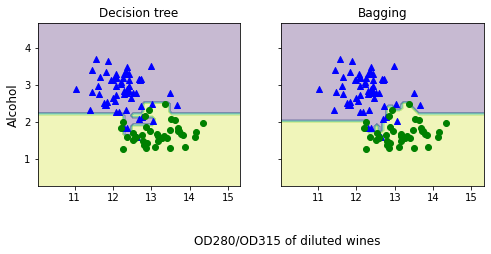

In [15]:
## here we just plot the decision boundaries of both the models and hence
## visualize the effectiveness of each model and verify it doesn't overfits in anyway 
x_min = X_train[:,0].min() - 1
x_max = X_train[:,0].max() + 1
y_min = X_train[:,1].min() - 1
y_max = X_train[:,1].max() + 1
xx , yy = np.meshgrid(np.arange(x_min,x_max,0.1),
                      np.arange(y_min,y_max,0.1))
f, axarr = plt.subplots(nrows = 1,ncols = 2,sharex = 'col',sharey = 'row',figsize = (8,3))
for idx,clf,tt in zip([0,1],[tree,bag],['Decision tree','Bagging']):
    clf.fit(X_train,y_train)
    
    Z = clf.predict(np.c_[xx.ravel(),yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx,yy,Z,alpha = 0.3)
    axarr[idx].scatter(X_train[y_train==0,0],
                       X_train[y_train==0,1],
                       c = 'blue',marker = '^')
    axarr[idx].scatter(X_train[y_train==1,0],
                       X_train[y_train==1,1],
                       c = 'green',marker = 'o')
    axarr[idx].set_title(tt)
    
axarr[0].set_ylabel('Alcohol',fontsize = 12)
plt.text(10.2,-1.2,s = 'OD280/OD315 of diluted wines',ha = 'center',va = 'center',fontsize = 12)
plt.show()

## Boosting
Boosting is another very popular method which comes under Ensemble Learning and its basic idea is that we train large number of weak learners which mostly learn from misclassified data points and hence we learn on top of these weak learners and hence build our model which would be able to perform realatively quite well as it would be able to generalize to the pattern of the data and since due to large ensembles we would have reduced variance.Here we would mostly discuss about the AdaBoost Boosting method which is used quite often.

### AdaBoost
Adaboost building on the ideas of Boosting Algorithms that they have low bias and variance but Adaboost in particular tends to have high variance,because as most algorithms used some sample of training data for different models adaboost tends to use the whole training set and reweights the misclassified examples so that they could be correctly classified later.

In [16]:
## Here we show the comparison between the base learner and ensemble learner
from sklearn.ensemble import AdaBoostClassifier
tree = DecisionTreeClassifier(criterion = 'entropy',random_state = 1,max_depth = 1)
ada = AdaBoostClassifier(base_estimator = tree,n_estimators = 500,learning_rate = 0.1,random_state = 1)
## Training the base learner
tree = tree.fit(X_train,y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train,y_train_pred)
tree_test = accuracy_score(y_test,y_test_pred)
print('Decision tree train/test accuracies: %.3f/%.3f' %(tree_train,tree_test))

## training the ensemble learner 
ada = ada.fit(X_train,y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train,y_train_pred)
ada_test = accuracy_score(y_test,y_test_pred)
print('AdaBoost train/test accuracies: %.3f/%.3f ' %(ada_train,ada_test))
## Hence we can see that adaboost tends to have higher testing accuracy but it also tends to have
## larger variance as stated above because there is a large difference between its training and testing accurarcy

Decision tree train/test accuracies: 0.916/0.875
AdaBoost train/test accuracies: 1.000/0.917 


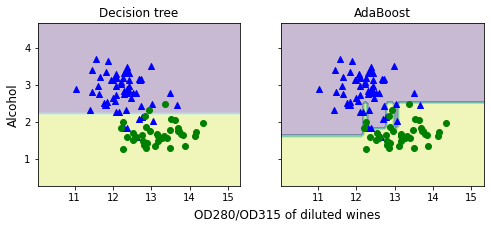

In [17]:
## Here we just plot the decision boundaries of both the algorithms and visualize their performances
x_min = X_train[:,0].min() - 1
x_max = X_train[:,0].max() + 1
y_min = X_train[:,1].min() - 1
y_max = X_train[:,1].max() + 1
xx , yy = np.meshgrid(np.arange(x_min,x_max,0.1),
                      np.arange(y_min,y_max,0.1))
f, axarr = plt.subplots(1,2,sharex = 'col',sharey = 'row',figsize = (8,3))
for idx,clf,tt in zip([0,1],[tree,ada],['Decision tree','AdaBoost']):
    clf.fit(X_train,y_train)
    
    Z = clf.predict(np.c_[xx.ravel(),yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx,yy,Z,alpha = 0.3)
    axarr[idx].scatter(X_train[y_train==0,0],
                       X_train[y_train==0,1],
                       c = 'blue',marker = '^')
    axarr[idx].scatter(X_train[y_train==1,0],
                       X_train[y_train==1,1],
                       c = 'green',marker = 'o')
    axarr[idx].set_title(tt)
    
axarr[0].set_ylabel('Alcohol',fontsize = 12)
plt.text(10.2,-0.5,s = 'OD280/OD315 of diluted wines',ha = 'center',va = 'center',fontsize = 12)
plt.show()
## Hence we can clearly see from the boundaries that the AdaBoost algorithm tends to overfit to the data as from its sharp decision boundary